<a href="https://colab.research.google.com/github/ClaireZixiWang/robustness-interpretability/blob/main/Robustness_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms 
import torchvision.models as models
import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load trained resnet 18 model


In [2]:
PATH = '/content/drive/MyDrive/resnet18/checkpoint_resnet18-base0100.pth.tar'
model_state_dict = torch.load(PATH)


In [10]:
model = models.resnet18(pretrained=False)
model.load_state_dict(model_state_dict)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Saliency map of resnet18 model

## Data and Data Loader

In [4]:

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/resnet18/cifar10-data',
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True)
                                            # transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1, 
                                          shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/resnet18/cifar10-data/cifar-10-python.tar.gz to /content/drive/MyDrive/resnet18/cifar10-data


(1, 3, 32, 32)


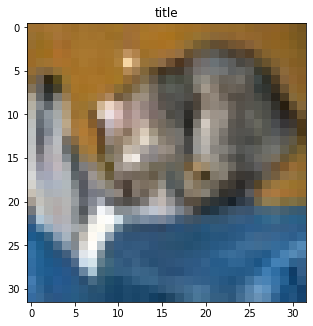

In [6]:
image, labels = iter(test_loader).next()
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(np.transpose(npimg.reshape(3,32,32),(1,2,0)))
plt.title('title')
plt.show()


In [7]:
# Set the device for the image
image = image.to(device)

In [8]:
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()


tensor([[[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
          [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
          [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
          ...,
          [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
          [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
          [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

         [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
          [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
          [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
          ...,
          [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
          [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
          [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

         [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
          [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
          [0.1843, 0.1294, 0.1412,  ..., 0

In [11]:
# Retrieve output from the image
output = model(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

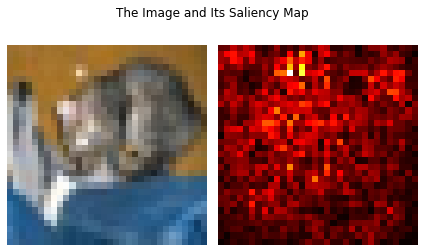

In [14]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
saliency = saliency.reshape(32, 32)

# Reshape the image
image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

# Adversarially train another resnet18 model with the same hyperparameter

# Saliency map